# Dolphin Whistle VAE-Based Self-Supervised Noise Reduction

In this notebook, we will construct a variational autoencoder (VAE)-based noise reduction algorithm. Similar to the anomaly detection algorithm, we train a model to reconstruct background events. This means that our model will learn to reconstruct background but NOT dolphin whistles. Thus, we can subtract the reconstruction from the original in order to obtain a noise-reduced sample.

# 1. Loading and Preprocessing the Data

We'll begin with some usual imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import pathlib
from fastai2.vision.all import *
import tqdm
from IPython.display import Audio
from itertools import count

import scipy.signal
from scipy import interpolate
import soundfile as sf
import librosa
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.neighbors import KNeighborsClassifier

import umap
import umap.plot

from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE
output_notebook(resources=INLINE)

Loading BokehJS ...

Next, we'll define a few constants:

In [2]:
DATA = 'DataTableV1.csv'

SR = 72000
WINDOW_S = 1.0
NFFT = 1024
HOP_LENGTH = None
WINDOW = scipy.signal.hanning
DB_TH = 1e-4
RES = 64
FMAX = 20000
FMIN = 5000
MAX = 1
MIN = 0
POWER_FACTOR=1000
WINDOW_WIDTH=int(WINDOW_S*SR)

LATENT_DIM=256
DIMS=(RES,RES,1)

MEMBERS = 1
EPOCHS_REPEAT = 10
EPOCHS = 10
BATCH_SIZE = 16
VERBOSE = 1

NEIGHBORS = 10

In [3]:
data_df = pd.read_csv(DATA)
detection_df = data_df[data_df.Detection!=0]
no_detection_df = data_df[data_df.Detection==0]

In [4]:
def load_detection(data_table, row_index=0, window_length=None):
    start = data_table.Starts_s.iloc[row_index]
    end = data_table.Ends_s.iloc[row_index]
    
    if window_length is None:
        window_length = end - start
    
    wf, _ = librosa.load('../'+data_table.Wav_Path.iloc[row_index], 
                         sr=None,
                         offset=start,
                         duration=window_length) 
    return wf

In [5]:
X1_audio = np.zeros((len(detection_df), int(SR*WINDOW_S)), dtype='float32')
Y1 = np.ones(X1_audio.shape[0], dtype='int32')
for i in tqdm.tqdm(range(len(detection_df))):
    X1_audio[i] = load_detection(detection_df, row_index=i, window_length=WINDOW_S)

100%|██████████| 1239/1239 [00:00<00:00, 1736.66it/s]


In [6]:
def load_no_detection(data_table, row_index=0, start=0, window_length=WINDOW_S):
    
    wf, _ = librosa.load('../'+data_table.Wav_Path.iloc[row_index], 
                         sr=None,
                         offset=start,
                         duration=window_length)      
    return wf

In [7]:
np.random.seed(0)
neg_indices_wav = np.random.randint(low=0, high=len(no_detection_df), size=X1_audio.shape[0])
neg_starts = np.random.uniform(low=50, high=850, size=X1_audio.shape[0])
X0_audio = np.zeros_like(X1_audio, dtype='float32')
Y0 = np.ones(X0_audio.shape[0], dtype='int32')
for i in tqdm.tqdm(range(X1_audio.shape[0])):
    wav_idx = neg_indices_wav[i]
    start = neg_starts[i]
    try:
        X0_audio[i] = load_no_detection(no_detection_df, row_index=wav_idx, start=start)
    except:
        print(wav_idx, start)
        break

100%|██████████| 1239/1239 [00:00<00:00, 2490.39it/s]


In [8]:
X0_audio.shape, Y0.shape, X1_audio.shape, Y1.shape

((1239, 72000), (1239,), (1239, 72000), (1239,))

# Constructing a Spectrogram Dataset

For simplicity and by convention, we'll employ a spectrogram-based representation. We have the custom Tensorflow layers at our disposal, so we'll apply them here.

In [9]:
class SpecGram(tf.keras.layers.Layer):    
    def __init__(self, name='spectrogram', **kwargs):
        super(SpecGram, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.spectrogram_representation(input_)

    @tf.function
    def spectrogram_representation(self, x):

        def construct_spectrogram(signal, sr=SR, nfft=NFFT, hoplength=HOP_LENGTH, win=WINDOW, db_th=DB_TH):
            if hoplength is None:
                hoplength = nfft//16

            _, _, spec = librosa.reassigned_spectrogram(y=signal, sr=sr, n_fft=nfft, hop_length=hoplength, window=win)
            spec_db = librosa.power_to_db(spec, amin=db_th)
            f_bins = librosa.core.fft_frequencies(sr=sr, n_fft=nfft)
            t_bins = np.linspace(0, len(signal)/sr, spec[0].shape[0])
            return t_bins,f_bins, spec_db

        def interp_spectrogram(spec, t, f, res=RES, fmax=FMAX, fmin=FMIN):
            if fmax is None:
                fmax = np.max(f)
            if fmin is None:
                fmax = np.min(f)

            interp_fx = interpolate.interp2d(t, f, spec, kind='cubic')
            ts_interp = np.linspace(np.min(t), np.max(t), res)
            freqs_interp = np.linspace(fmin, fmax, res)
            spec_interp = interp_fx(ts_interp, freqs_interp)
            return spec_interp, freqs_interp, ts_interp

        def generate_representation(waveform, sr=SR, nfft=NFFT, db_th=DB_TH, win=WINDOW, res=RES, fmax=FMAX, fmin=FMIN):
            batch_size= waveform.shape[0]
            reps = np.zeros((batch_size, res, res))
            for n in range(batch_size):
                t, f, Sxx = construct_spectrogram(waveform[n,:], sr=sr, nfft=nfft, win=win, db_th=db_th)
                rep, _, _ = interp_spectrogram(Sxx, t, f, res, fmax, fmin)
                reps[n, :, :] = rep
            return reps.astype('float32')

        @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
        def tf_rep(input_):
            y = tf.numpy_function(generate_representation, [input_], tf.float32)
            return y

        x = tf.cast(x, tf.float32)
        result = (tf_rep(x))
        return tf.keras.backend.reshape(result, (-1, RES, RES))

    def get_config(self):
        config = super(SpecGram, self).get_config()
        return config

    def vis_rep(self, X_examples, Y_examples):
        N_examples = X_examples.shape[0]

        def is_sqrt(x):
            sq = np.sqrt(x)
            return (sq - np.floor(sq))==0

        if ~is_sqrt(N_examples):
            raise ValueError('Choose a perfect square number of examples')
        else:
            plot_dim = int(np.sqrt(N_examples))

        reps = self.spectrogram_representation(X_examples)
        fig, axes = plt.subplots(plot_dim, plot_dim, figsize=(15, 10))
        axs = axes.flatten()
        for n in range(N_examples):
            axs[n].imshow(reps[n, :, :].numpy(), cmap='magma')
            axs[n].invert_yaxis()
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].set_title(f'Class {Y_examples[n]}')

Let's see what these look like:

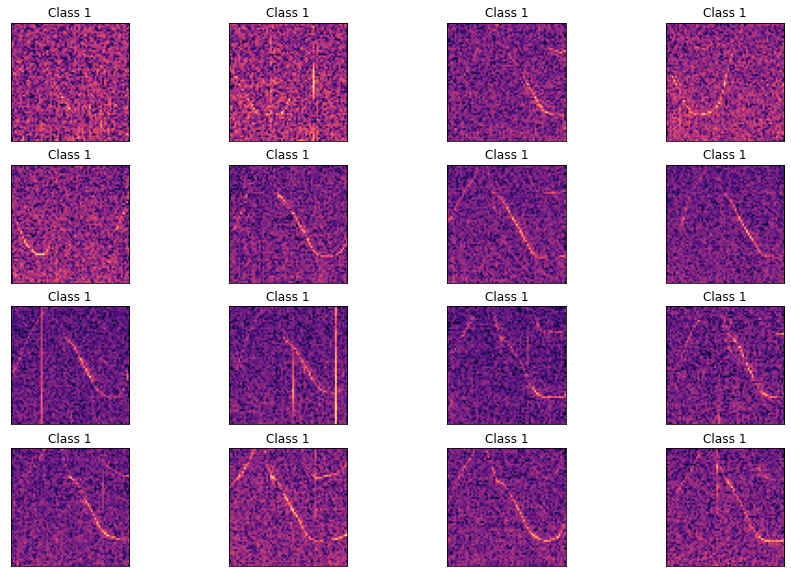

In [10]:
SpecGram().vis_rep(X1_audio[0:16], Y1[0:16])

Looks good so far. Before we proceed with any machine learning, we'll have to normalize the inputs. First, we'll use a min-max scaler in order to reduce the magnitudes of the features. We'll follow up with a novel technique in which we fix the sum of features in a given spectrogram to a constant value. Since spectrograms represent a signal's acoustic power at a given time and frequency, this means that we are making sure that each audio segment contains the same amount of power.

In [11]:
class MinMaxScaler(tf.keras.layers.Layer):
    def __init__(self, name='min_max_scaler', **kwargs):
        super(MinMaxScaler, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.min_max_scaler(input_)

    @tf.function
    def min_max_scaler(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)

        _min = tf.math.reduce_min(x, axis=2, keepdims=True, name=None)
        _min = tf.math.reduce_min(_min, axis=1, keepdims=True, name=None)

        _max = tf.math.reduce_max(x, axis=2, keepdims=True, name=None)
        _max = tf.math.reduce_max(_max, axis=1, keepdims=True, name=None)

        x_norm = (MAX - MIN) * (x - _min) / (_max - _min) + MIN
        return x_norm

    def get_config(self):
        config = super(MinMaxScaler, self).get_config()
        return config

In [12]:
class PowerNormalizer(tf.keras.layers.Layer):
    def __init__(self, name='normalizer_scaler', **kwargs):
        super(PowerNormalizer, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.normalizer(input_)

    @tf.function
    def normalizer(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)
        _sum = tf.math.reduce_sum(x, axis=2, keepdims=True)
        _sum = tf.math.reduce_sum(_sum, axis=1, keepdims=True)
        x_norm = tf.math.divide(x, _sum)
        x_norm = POWER_FACTOR * x_norm
        return x_norm

    def get_config(self):
        config = super(PowerNormalizer, self).get_config()
        return config

Now we can construct our spectrogram builder.

In [13]:
class SpecBuilder(tf.keras.Model):
    def __init__(self):
        super(SpecBuilder, self).__init__()
        self.builder = self.build_spec_model()

    def build_spec_model(self):
        spec_inputs = tf.keras.Input(shape=(WINDOW_WIDTH,))
        x = SpecGram()(spec_inputs)
        x = MinMaxScaler()(x)
        x = PowerNormalizer()(x)
        outputs = tf.keras.layers.Reshape((RES, RES, 1), input_shape=(RES, RES))(x)

        spec_model = tf.keras.Model(spec_inputs, outputs, name='spec_builder')
        return spec_model

    def call(self, x):
        return self.builder(x)
spec_builder = SpecBuilder().builder
spec_builder.summary()

Model: "spec_builder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72000)]           0         
_________________________________________________________________
spectrogram (SpecGram)       (None, 64, 64)            0         
_________________________________________________________________
min_max_scaler (MinMaxScaler (None, 64, 64)            0         
_________________________________________________________________
normalizer_scaler (PowerNorm (None, 64, 64)            0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 1)         0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


We are now ready to construct our spectrogram datasets.

In [14]:
X1_specs = np.zeros((X1_audio.shape[0], RES, RES, 1), dtype='float32')
for i in tqdm.tqdm(range(X1_audio.shape[0])):
    X1_specs[i] = spec_builder(np.expand_dims(X1_audio[i], axis=0)).numpy()

100%|██████████| 1239/1239 [02:31<00:00,  8.16it/s]


In [15]:
X0_specs = np.zeros((X0_audio.shape[0], RES, RES, 1), dtype='float32')
for i in tqdm.tqdm(range(X0_audio.shape[0])):
    X0_specs[i] = spec_builder(np.expand_dims(X0_audio[i], axis=0)).numpy()

100%|██████████| 1239/1239 [02:28<00:00,  8.32it/s]


Lastly, we'll just split the no-detection spectrograms into a training set and a testing set.

In [16]:
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0_specs, Y0, test_size=0.2, random_state=42)
X1 = X1_specs
X0_train.shape, X0_test.shape, Y0_train.shape, Y0_test.shape, X1.shape, Y1.shape

((991, 64, 64, 1),
 (248, 64, 64, 1),
 (991,),
 (248,),
 (1239, 64, 64, 1),
 (1239,))

In [17]:
N_TRAIN_BATCHES =int(X0_train.shape[0]/BATCH_SIZE)

In [18]:
train0_dataset = (tf.data.Dataset.from_tensor_slices(X0_train)
                 .shuffle(X0_train.shape[0]).batch(BATCH_SIZE))
test0_dataset = (tf.data.Dataset.from_tensor_slices(X0_test)
                .shuffle(X0_test.shape[0]).batch(BATCH_SIZE))
test1_dataset = (tf.data.Dataset.from_tensor_slices(X1)
                .shuffle(X1.shape[0]).batch(BATCH_SIZE))

In [19]:
example_data = next(iter(train0_dataset))

In [20]:
np.save('Models_and_Arrays/X0_train.npy', X0_train)
np.save('Models_and_Arrays/X0_test.npy', X0_test)
np.save('Models_and_Arrays/X1.npy', X1)

# 3. Training a VAE

Now that we have our data ready to go, let's construct our VAE.

In [21]:
class Sampling(tf.keras.layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [22]:
class Encoder(tf.keras.Model):

    def __init__(self, latent_dim=LATENT_DIM, dims=DIMS):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.dims = dims

        self.encoder = self.construct_encoder()


    def construct_encoder(self):
        inputs = tf.keras.Input(shape=self.dims)
        x = tf.keras.layers.Conv2D(filters=32, 
                                   kernel_size=3, 
                                   strides=(2, 2), 
                                   activation=tf.nn.leaky_relu)(inputs)
        x = tf.keras.layers.Conv2D(filters=64, 
                                   kernel_size=3, 
                                   strides=(2, 2), 
                                   activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2D(filters=128, 
                                   kernel_size=3, 
                                   strides=(2, 2), 
                                   activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2D(filters=256, 
                                   kernel_size=3, 
                                   strides=(2, 2), 
                                   activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2D(filters=256, 
                                   kernel_size=3, 
                                   strides=(2, 2), 
                                   activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        z_mean = tf.keras.layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = tf.keras.layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        encoder = tf.keras.Model(inputs=inputs, outputs=[z_mean, z_log_var, z], name='encoder')
        return encoder

    def call(self, inputs):
        return self.encoder(inputs)
"""
EXAMPLE TESTS:
"""
encoder_example = Encoder(latent_dim=LATENT_DIM, dims=(RES,RES,1))
encoder_example.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 31, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 15, 15, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 128)    73856       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [23]:
class Decoder(tf.keras.Model):

    def __init__(self, latent_dim=LATENT_DIM, res=RES):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.res = res

        self.decoder = self.construct_decoder()


    def construct_decoder(self):
        inputs = tf.keras.Input(shape=(self.latent_dim,))
        x = tf.keras.layers.Dense(units=(RES // 32) * (RES // 32) * 256, activation='relu')(inputs)
        x = tf.keras.layers.Reshape(target_shape=((RES // 32), (RES // 32), 256))(x)
        x = tf.keras.layers.Conv2DTranspose(filters=256, 
                                            kernel_size=3, 
                                            strides=(2, 2), 
                                            padding='same', 
                                            activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2DTranspose(filters=256, 
                                            kernel_size=3, 
                                            strides=(2, 2), 
                                            padding='same', 
                                            activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2DTranspose(filters=128, 
                                            kernel_size=3, 
                                            strides=(2, 2), 
                                            padding='same', 
                                            activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2DTranspose(filters=64, 
                                            kernel_size=3, 
                                            strides=(2, 2), 
                                            padding='same', 
                                            activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2DTranspose(filters=32, 
                                            kernel_size=3, 
                                            strides=(2, 2), 
                                            padding='same', 
                                            activation=tf.nn.leaky_relu)(x)
        outputs = tf.keras.layers.Conv2DTranspose(filters=1, 
                                            kernel_size=3, 
                                            strides=(1, 1), 
                                            padding='same', 
                                            activation='sigmoid')(x)
        decoder = tf.keras.Model(inputs=inputs, outputs=outputs, name='decoder')
        return decoder

    def call(self, inputs):
        return self.decoder(inputs)

"""
EXAMPLE TESTS:
"""
decoder_example = Decoder(latent_dim=LATENT_DIM)
decoder_example.decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        7379

In [24]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    @tf.function
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            
            reconstruction_loss = tf.reduce_mean(tf.math.square(data - reconstruction))
            reconstruction_loss *= 32*32
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [25]:
def visualize_reconstructions(model, example_data, epoch, step, max_=0.7, save=True):
    xg = model.decoder(model.encoder(example_data))
    
    fig, axes = plt.subplots(4,4,figsize=(8,8))
    axs = axes.flatten()
    axs[0].set_title('Data')
    axs[1].set_title('Reconstruction')
    axs[2].set_title('Data')
    axs[3].set_title('Reconstruction')
    for i in range(8):
        axs[2*i].imshow(example_data[i, :, :, 0].numpy(), cmap='magma', vmin=0, vmax=max_)
        axs[2*i].invert_yaxis()
        axs[2*i].axis('off')
            
        axs[2*i+1].imshow(xg[i, :, :, 0].numpy(), cmap='magma', vmin=0, vmax=max_)
        axs[2*i+1].invert_yaxis()
        axs[2*i+1].axis('off')
    
    if save:
        plt.savefig('reconstruction_at_epoch_{:04d}_step_{:04d}.png'.format(epoch, step))
    plt.show()

Time to build and train the ensemble!

MODEL: 0
     EPOCH: 0
Epoch 1/10
62/62 [==============================] - 2s 27ms/step - loss: 14.8393 - reconstruction_loss: 14.8326 - kl_loss: 0.0067
Epoch 2/10
62/62 [==============================] - 1s 21ms/step - loss: 6.0521 - reconstruction_loss: 6.0520 - kl_loss: 8.6571e-05
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 6.0179 - reconstruction_loss: 6.0178 - kl_loss: 7.4212e-05
Epoch 4/10
62/62 [==============================] - 1s 21ms/step - loss: 5.9563 - reconstruction_loss: 5.9563 - kl_loss: 8.4317e-05
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 5.9905 - reconstruction_loss: 5.9904 - kl_loss: 1.0749e-04
Epoch 6/10
62/62 [==============================] - 1s 21ms/step - loss: 5.9946 - reconstruction_loss: 5.9944 - kl_loss: 1.9901e-04
Epoch 7/10
62/62 [==============================] - 1s 21ms/step - loss: 5.7481 - reconstruction_loss: 5.7345 - kl_loss: 0.0135
Epoch 8/10
62/62 [==============================] - 1s 21ms

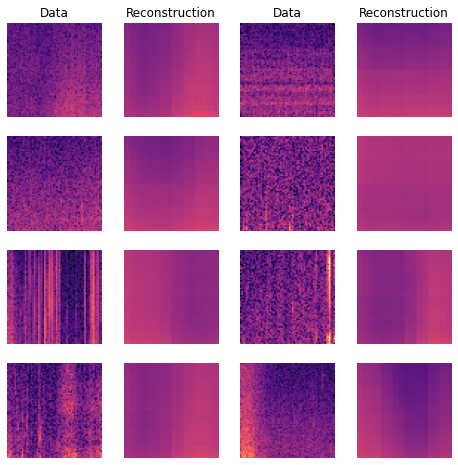

     EPOCH: 10
Epoch 1/10
62/62 [==============================] - 1s 21ms/step - loss: 5.2991 - reconstruction_loss: 5.2430 - kl_loss: 0.0561
Epoch 2/10
62/62 [==============================] - 1s 21ms/step - loss: 5.2671 - reconstruction_loss: 5.2016 - kl_loss: 0.0656
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 5.1506 - reconstruction_loss: 5.0800 - kl_loss: 0.0706
Epoch 4/10
62/62 [==============================] - 1s 21ms/step - loss: 5.0985 - reconstruction_loss: 5.0229 - kl_loss: 0.0756
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 5.1033 - reconstruction_loss: 5.0356 - kl_loss: 0.0677
Epoch 6/10
62/62 [==============================] - 1s 21ms/step - loss: 5.0979 - reconstruction_loss: 5.0272 - kl_loss: 0.0707
Epoch 7/10
62/62 [==============================] - 1s 21ms/step - loss: 5.0439 - reconstruction_loss: 4.9696 - kl_loss: 0.0743
Epoch 8/10
62/62 [==============================] - 1s 21ms/step - loss: 5.0440 - reconst

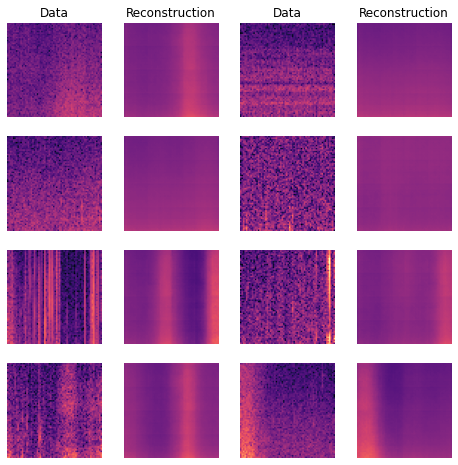

     EPOCH: 20
Epoch 1/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9745 - reconstruction_loss: 4.8936 - kl_loss: 0.0809
Epoch 2/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9761 - reconstruction_loss: 4.8952 - kl_loss: 0.0809
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9843 - reconstruction_loss: 4.9033 - kl_loss: 0.0809
Epoch 4/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9536 - reconstruction_loss: 4.8720 - kl_loss: 0.0816
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9440 - reconstruction_loss: 4.8615 - kl_loss: 0.0825
Epoch 6/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9453 - reconstruction_loss: 4.8633 - kl_loss: 0.0820
Epoch 7/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9437 - reconstruction_loss: 4.8593 - kl_loss: 0.0843
Epoch 8/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9496 - reconst

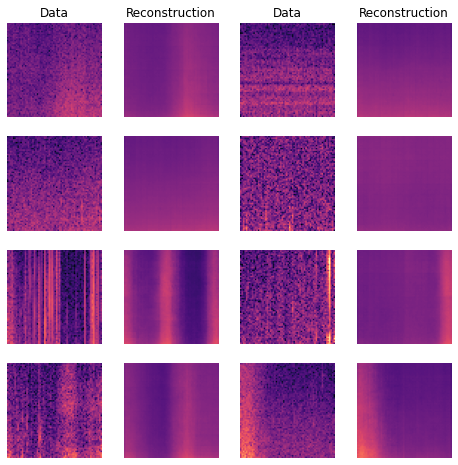

     EPOCH: 30
Epoch 1/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9013 - reconstruction_loss: 4.8170 - kl_loss: 0.0843
Epoch 2/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9152 - reconstruction_loss: 4.8288 - kl_loss: 0.0864
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8864 - reconstruction_loss: 4.8009 - kl_loss: 0.0854
Epoch 4/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8997 - reconstruction_loss: 4.8161 - kl_loss: 0.0836
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9031 - reconstruction_loss: 4.8168 - kl_loss: 0.0863
Epoch 6/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9022 - reconstruction_loss: 4.8127 - kl_loss: 0.0895
Epoch 7/10
62/62 [==============================] - 1s 21ms/step - loss: 4.9108 - reconstruction_loss: 4.8239 - kl_loss: 0.0869
Epoch 8/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8759 - reconst

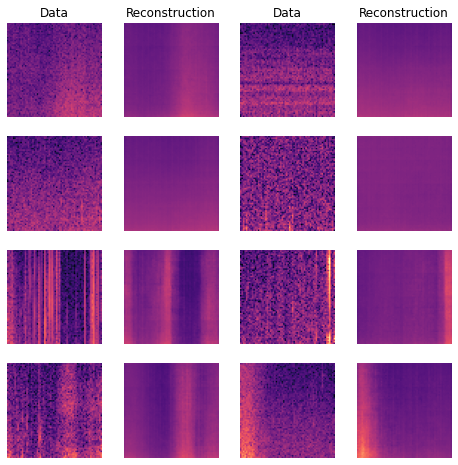

     EPOCH: 40
Epoch 1/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8662 - reconstruction_loss: 4.7776 - kl_loss: 0.0886
Epoch 2/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8437 - reconstruction_loss: 4.7541 - kl_loss: 0.0896
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8899 - reconstruction_loss: 4.8024 - kl_loss: 0.0875
Epoch 4/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8514 - reconstruction_loss: 4.7620 - kl_loss: 0.0894
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8520 - reconstruction_loss: 4.7651 - kl_loss: 0.0869
Epoch 6/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8204 - reconstruction_loss: 4.7320 - kl_loss: 0.0884
Epoch 7/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8366 - reconstruction_loss: 4.7477 - kl_loss: 0.0889
Epoch 8/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8193 - reconst

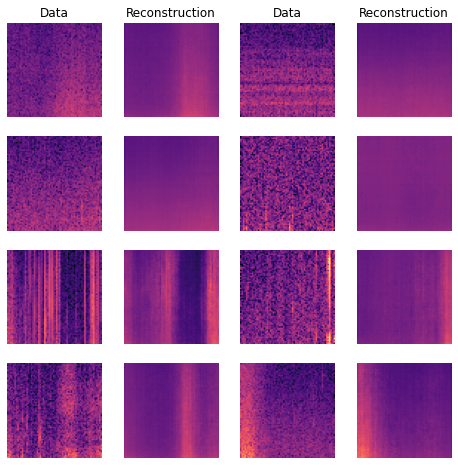

     EPOCH: 50
Epoch 1/10
62/62 [==============================] - 1s 21ms/step - loss: 4.8219 - reconstruction_loss: 4.7320 - kl_loss: 0.0899
Epoch 2/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7908 - reconstruction_loss: 4.7015 - kl_loss: 0.0893
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7979 - reconstruction_loss: 4.7086 - kl_loss: 0.0893
Epoch 4/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7848 - reconstruction_loss: 4.6978 - kl_loss: 0.0870
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7814 - reconstruction_loss: 4.6924 - kl_loss: 0.0890
Epoch 6/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7782 - reconstruction_loss: 4.6897 - kl_loss: 0.0885
Epoch 7/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7693 - reconstruction_loss: 4.6833 - kl_loss: 0.0860
Epoch 8/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7542 - reconst

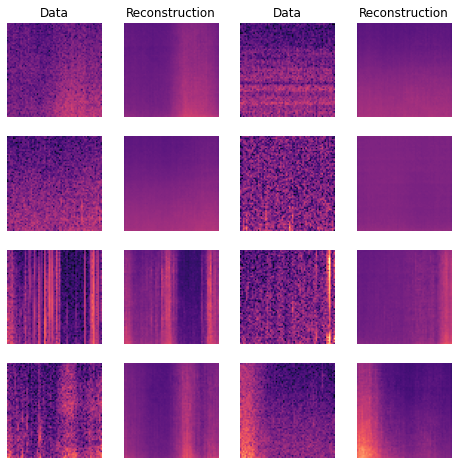

     EPOCH: 60
Epoch 1/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7627 - reconstruction_loss: 4.6753 - kl_loss: 0.0874
Epoch 2/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7479 - reconstruction_loss: 4.6590 - kl_loss: 0.0889
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7357 - reconstruction_loss: 4.6467 - kl_loss: 0.0889
Epoch 4/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7208 - reconstruction_loss: 4.6316 - kl_loss: 0.0893
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 4.7038 - reconstruction_loss: 4.6144 - kl_loss: 0.0894
Epoch 6/10
62/62 [==============================] - 1s 21ms/step - loss: 4.6810 - reconstruction_loss: 4.5928 - kl_loss: 0.0881
Epoch 7/10
62/62 [==============================] - 1s 21ms/step - loss: 4.6994 - reconstruction_loss: 4.6120 - kl_loss: 0.0874
Epoch 8/10
62/62 [==============================] - 1s 21ms/step - loss: 4.6868 - reconst

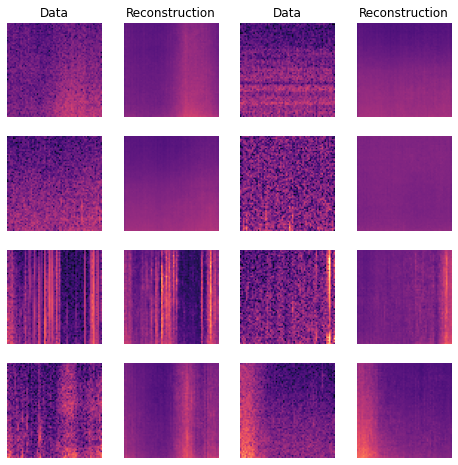

     EPOCH: 70
Epoch 1/10
62/62 [==============================] - 1s 21ms/step - loss: 4.6488 - reconstruction_loss: 4.5584 - kl_loss: 0.0904
Epoch 2/10
62/62 [==============================] - 1s 21ms/step - loss: 4.6632 - reconstruction_loss: 4.5751 - kl_loss: 0.0881
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 4.6333 - reconstruction_loss: 4.5421 - kl_loss: 0.0912
Epoch 4/10
62/62 [==============================] - 1s 21ms/step - loss: 4.6484 - reconstruction_loss: 4.5593 - kl_loss: 0.0891
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 4.6538 - reconstruction_loss: 4.5645 - kl_loss: 0.0893
Epoch 6/10
62/62 [==============================] - 1s 21ms/step - loss: 4.6412 - reconstruction_loss: 4.5529 - kl_loss: 0.0883
Epoch 7/10
62/62 [==============================] - 1s 21ms/step - loss: 4.6378 - reconstruction_loss: 4.5470 - kl_loss: 0.0908
Epoch 8/10
62/62 [==============================] - 1s 21ms/step - loss: 4.6132 - reconst

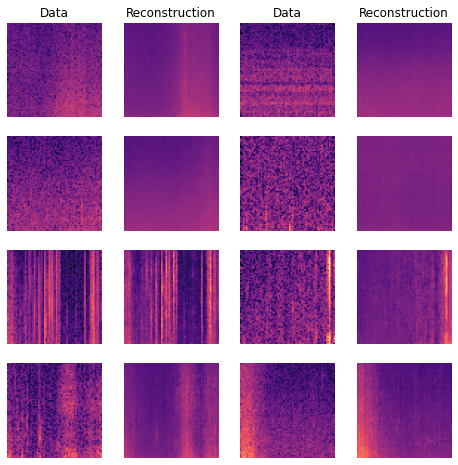

     EPOCH: 80
Epoch 1/10
62/62 [==============================] - 1s 21ms/step - loss: 4.5520 - reconstruction_loss: 4.4600 - kl_loss: 0.0920
Epoch 2/10
62/62 [==============================] - 1s 21ms/step - loss: 4.5496 - reconstruction_loss: 4.4574 - kl_loss: 0.0922
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 4.5854 - reconstruction_loss: 4.4927 - kl_loss: 0.0926
Epoch 4/10
62/62 [==============================] - 1s 21ms/step - loss: 4.5426 - reconstruction_loss: 4.4478 - kl_loss: 0.0948
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 4.5352 - reconstruction_loss: 4.4408 - kl_loss: 0.0944
Epoch 6/10
62/62 [==============================] - 1s 21ms/step - loss: 4.5602 - reconstruction_loss: 4.4643 - kl_loss: 0.0959
Epoch 7/10
62/62 [==============================] - 1s 21ms/step - loss: 4.5403 - reconstruction_loss: 4.4454 - kl_loss: 0.0949
Epoch 8/10
62/62 [==============================] - 1s 21ms/step - loss: 4.5193 - reconst

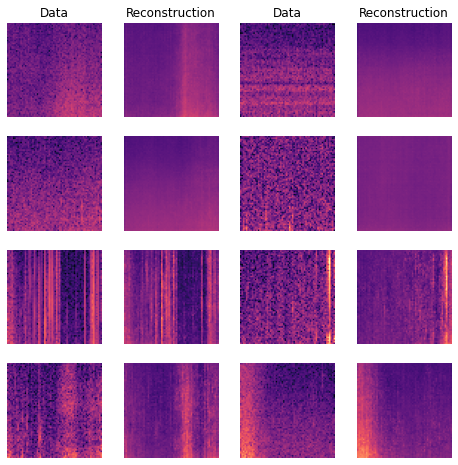

     EPOCH: 90
Epoch 1/10
62/62 [==============================] - 1s 21ms/step - loss: 4.4750 - reconstruction_loss: 4.3791 - kl_loss: 0.0959
Epoch 2/10
62/62 [==============================] - 1s 21ms/step - loss: 4.4476 - reconstruction_loss: 4.3505 - kl_loss: 0.0971
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 4.4589 - reconstruction_loss: 4.3618 - kl_loss: 0.0971
Epoch 4/10
62/62 [==============================] - 1s 21ms/step - loss: 4.4629 - reconstruction_loss: 4.3664 - kl_loss: 0.0965
Epoch 5/10
62/62 [==============================] - 1s 21ms/step - loss: 4.4400 - reconstruction_loss: 4.3414 - kl_loss: 0.0986
Epoch 6/10
62/62 [==============================] - 1s 21ms/step - loss: 4.4455 - reconstruction_loss: 4.3460 - kl_loss: 0.0995
Epoch 7/10
62/62 [==============================] - 1s 21ms/step - loss: 4.4140 - reconstruction_loss: 4.3158 - kl_loss: 0.0982
Epoch 8/10
62/62 [==============================] - 1s 21ms/step - loss: 4.4091 - reconst

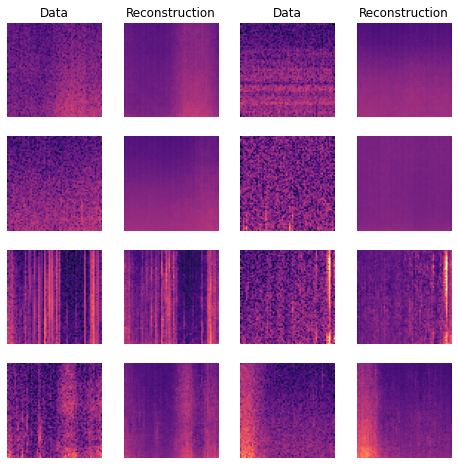

In [26]:
ensemble = []
for i in range(MEMBERS):
    print(f'MODEL: {i}')
    encoder = Encoder()
    decoder = Decoder()

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    
    for j in range(EPOCHS_REPEAT):
        print(f'     EPOCH: {EPOCHS*j}')
        vae.fit(X0_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE)
        visualize_reconstructions(vae, example_data, 999, 999, save=False)
    ensemble.append(vae)

In [28]:
STOP

NameError: name 'STOP' is not defined

In [29]:
example0_train = next(iter(train0_dataset))

In [30]:
example0_test = next(iter(test0_dataset))

In [31]:
example1_test = next(iter(test1_dataset))

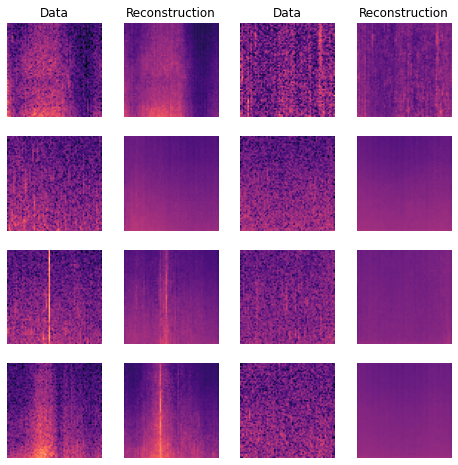

In [32]:
visualize_reconstructions(ensemble[0], example0_train, 999, 999, save=False)

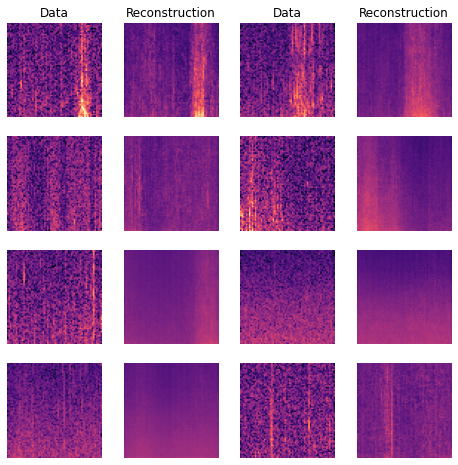

In [33]:
visualize_reconstructions(ensemble[0], example0_test, 999, 999, save=False)

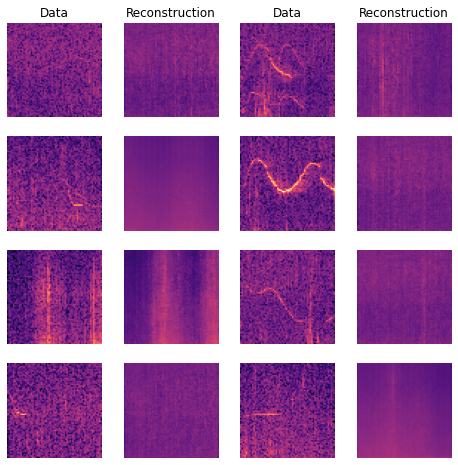

In [34]:
visualize_reconstructions(ensemble[0], example1_test, 999, 999, save=False)

In [37]:
def noise_reduce(y_pred, y_true):
    return y_true - y_pred

In [46]:
def plot_noiseless(model, example_data, n_samples=4, max_=0.7):
    xg = model.decoder(model.encoder(example_data))
    noiseless = noise_reduce(xg, example_data) 
    
    fig, axes = plt.subplots(4,3,figsize=(8,8))
    axs = axes.flatten()
    axs[0].set_title('Data')
    axs[1].set_title('Reconstruction')
    axs[2].set_title('Data')
    axs[3].set_title('Reconstruction')
    for i in range(n_samples):
        axs[3*i].imshow(example_data[i, :, :, 0].numpy(), cmap='magma', vmin=0, vmax=max_)
        axs[3*i].invert_yaxis()
        axs[3*i].set_title('Original')
        axs[3*i].axis('off')
            
        axs[3*i+1].imshow(xg[i, :, :, 0].numpy(), cmap='magma', vmin=0, vmax=max_)
        axs[3*i+1].invert_yaxis()
        axs[3*i+1].set_title('Reconstruction')
        axs[3*i+1].axis('off')
        
        axs[3*i+2].imshow(noiseless[i, :, :, 0].numpy(), cmap='magma', vmin=0, vmax=max_/2)
        axs[3*i+2].invert_yaxis()
        axs[3*i+2].set_title('Noiseless')
        axs[3*i+2].axis('off')
    plt.show()

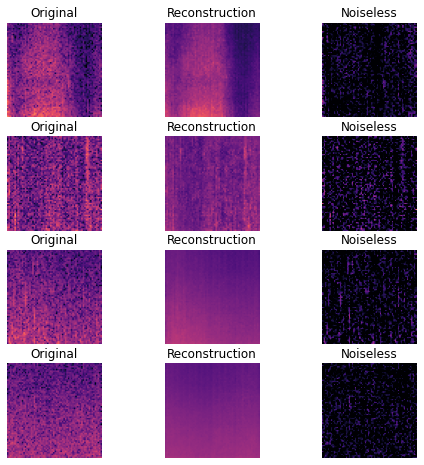

In [47]:
plot_noiseless(ensemble[0], example0_train)

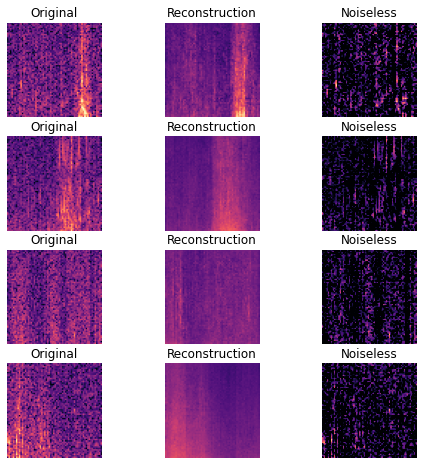

In [48]:
plot_noiseless(ensemble[0], example0_test)

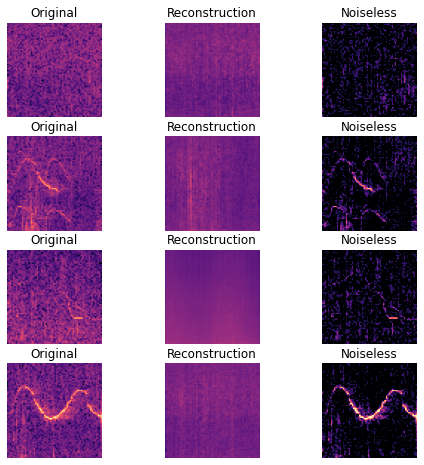

In [49]:
plot_noiseless(ensemble[0], example1_test)

As we can see, we obtain a noise-reduced version of the input signal. This pipeline represents a novel self-supervised approach to noise reduction.